In [1]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
import os
import pdb
from scipy.sparse.linalg import lsqr
from numpy.linalg import lstsq
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

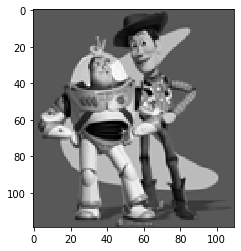

In [2]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2RGB)
plt.imshow(toy_img)

## Part 1 Toy Problem (20 pts)

In [3]:
def toy_reconstruct(toy_img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    # dim of source img
    im = np.asarray(toy_img[:,:,0],dtype=np.float64)/255.0
    im_h, im_w = im.shape[0],im.shape[1] 
    
    # maps each pixel to a variable number
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
    
    # piazza post, ask about border case and first pixel
    n_constraints = im_h*(im_w-1) + (im_h-1)*im_w + 1 
    e = 0
    num_pixels = im_h* im_w
    
    # sparse matrix for A and b
    A = np.zeros((n_constraints,num_pixels),dtype=np.float64)
    b = np.zeros(n_constraints,dtype=np.float64)
    #pdb.set_trace()
    
    # obj 3, top left pixel (plus one pixel intensity)
    A[e][im2var[0][0]] = 1
    b[e] = im[0][0]
    e = e + 1;
    
    # calc gradient for each pixel
    for y in range(im2var.shape[0]):
        for x in range(im2var.shape[1]):
            
            #obj 1
            if x != im2var.shape[1]-1:
                A[e, im2var[y][x+1]] = 1
                A[e, im2var[y][x]] = -1
                b[e] = im[y][x+1] - im[y][x]
                e = e + 1
            
            if y != im2var.shape[0]-1:
                #obj 2
                A[e, im2var[y+1][x]] = 1
                A[e, im2var[y][x]] = -1
                b[e] = im[y+1][x] - im[y][x]  
                e = e + 1
    
    # solve for v with least square 
    v = lsqr(csr_matrix(A, dtype=np.float64), b, atol = 1e-14, btol=1e-14)
    
    # img with 1 channel
    res_ch1 = np.resize(v[0],(im_w, im_h)).T
    #pdb.set_trace()
    
    # image with v in all 3 channels
    res_ch3 = np.repeat(res_ch1[:,:,np.newaxis],3,axis=2)

    return res_ch3*255.0
   

In [4]:
im_out = toy_reconstruct(toy_img)
if im_out is not None and im_out.any():
    print("Error is: ", np.sqrt(((im_out - toy_img)**2).sum()))

Error is:  9.25090233078333e-08


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


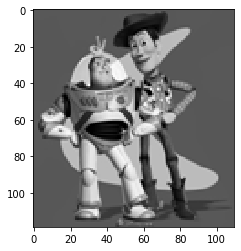

In [5]:
plt.imshow(im_out/255)

## Preparation

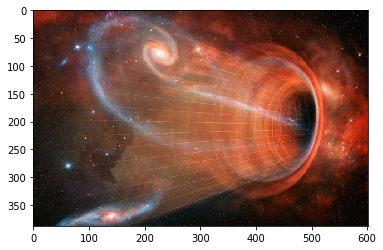

In [62]:
# Feel free to change image
background_img = cv2.cvtColor(cv2.imread('samples/space.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


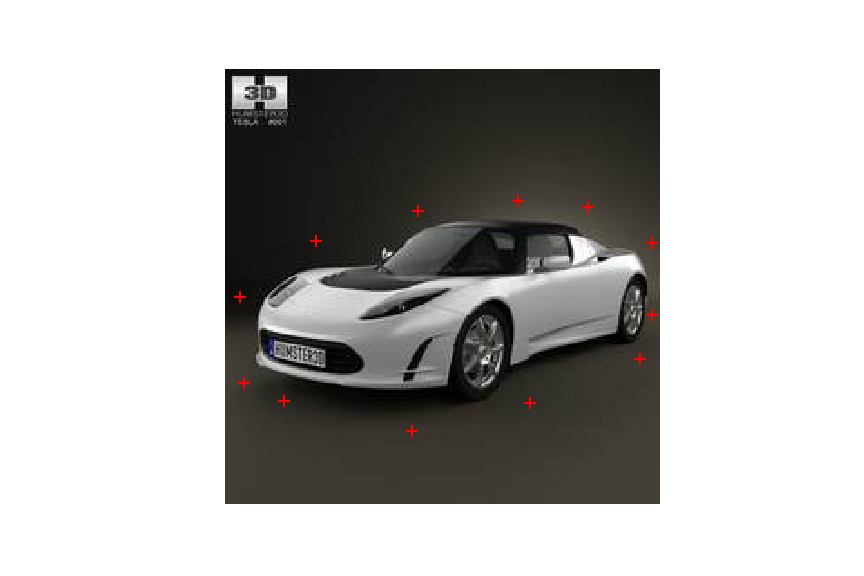

In [63]:
# Feel free to change image
object_img = cv2.cvtColor(cv2.imread('samples/roadster2.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

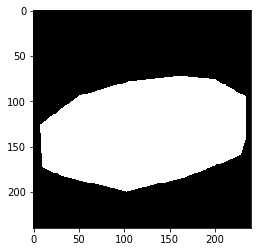

In [64]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


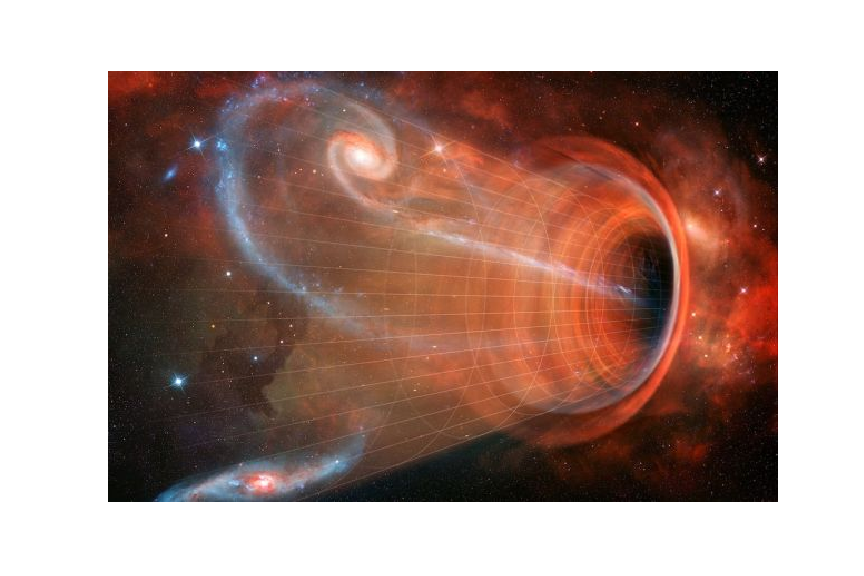

In [76]:
%matplotlib notebook
import matplotlib.pyplot as plt

bottom_center = specify_bottom_center(background_img)

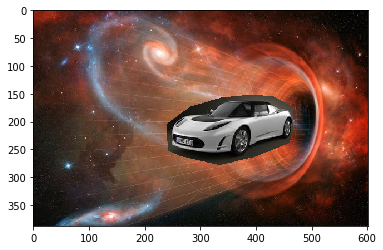

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object, object_mask = align_source(object_img, mask, background_img, bottom_center)

## Part 2 Poisson Blending (50 pts)

In [78]:
def poisson_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    images = [cropped_object[:,:,0],cropped_object[:,:,1],cropped_object[:,:,2]]
    res_3channels = np.zeros((cropped_object.shape[0],cropped_object.shape[1],cropped_object.shape[2]),dtype=np.float64)
    channel_cnt = 0
    
    # 3 channels
    for im in images:
        print("Channel "+str(channel_cnt+1))
        # dim of source img
        im = im/255
        im_h, im_w = im.shape[0],im.shape[1] 

        # maps each pixel to a variable number
        #im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
        im2var = []
        cnt = 0
        for row in range(im_h):
            col_arr = []
            for col in range(im_w):
                if object_mask[row][col]==1:
                    col_arr.append(cnt)
                    cnt+=1
                else:
                    col_arr.append(0)
            im2var.append(col_arr)
        

        # piazza post, ask about border case and first pixel
        #n_constraints = 2*im_h*(im_w-1) + 2*(im_h-1)*im_w + 1 
        n_constraints = 4*cnt
        num_pixels = cnt
        e = 0

        # sparse matrix for A and b
        #A = np.zeros((n_constraints,num_pixels),dtype=np.float64)
        A = lil_matrix((n_constraints,num_pixels),dtype=np.float64)
        b = np.zeros(n_constraints,dtype=np.float64)

        print("Implementing Constraints")
        # calc gradient for each pixel
        for y in range(im_h):
            for x in range(im_w):
                # if pixel is part of source
                if object_mask[y][x]==1:
                    
                    if object_mask[y][x+1]==1:
                        #obj 1 checks right 
                        A[e, im2var[y][x+1]] = -1
                        A[e, im2var[y][x]] = 1
                        b[e] =  im[y][x] - im[y][x+1]          
                        e = e + 1
                    else:
                        A[e, im2var[y][x]] = 1
                        b[e] = im[y][x] - im[y][x+1] + background_img[y][x+1][channel_cnt]            
                        e = e + 1

                    if object_mask[y+1][x]==1:
                        #obj 2 checks down 
                        A[e, im2var[y+1][x]] = -1
                        A[e, im2var[y][x]] = 1
                        b[e] =  im[y][x] - im[y+1][x]          
                        e = e + 1
                    else:
                        A[e, im2var[y][x]] = 1
                        b[e] = im[y][x] - im[y+1][x] + background_img[y+1][x][channel_cnt]            
                        e = e + 1
                

                    if object_mask[y][x-1]==1:
                        #obj 3 left  
                        A[e, im2var[y][x-1]] = -1
                        A[e, im2var[y][x]] = 1
                        b[e] =  im[y][x] - im[y][x-1]          
                        e = e + 1
                    else:
                        A[e, im2var[y][x]] = 1
                        b[e] = im[y][x] - im[y][x-1] + background_img[y][x-1][channel_cnt]            
                        e = e + 1
                    
                    if object_mask[y-1][x]==1:
                        #obj 4 checks up 
                        A[e, im2var[y-1][x]] = -1
                        A[e, im2var[y][x]] = 1
                        b[e] =  im[y][x] - im[y-1][x]          
                        e = e + 1
                    else:
                        A[e, im2var[y][x]] = 1
                        b[e] = im[y][x] - im[y-1][x] + background_img[y-1][x][channel_cnt]            
                        e = e + 1

        # solve for v with least square 
        print("Solving constraints")
        v = lsqr(csr_matrix(A, dtype=np.float64), b,atol = 1e-14, btol=1e-14)
       
        # img with 1 channel
        #res_1channel = np.resize(v[0],(im_w, im_h)).T
        res_cnt = 0
        for row in range(im_h):
            for col in range(im_w):
                if object_mask[row][col]==1:
                    res_3channels[row][col][channel_cnt] = v[0][res_cnt]
                    res_cnt += 1
                else:
                    res_3channels[row][col][channel_cnt] = background_img[row][col][channel_cnt]
            
        #pdb.set_trace()
        channel_cnt+=1
    
    return res_3channels

Channel 1
Implementing Constraints
Solving constraints
Channel 2
Implementing Constraints
Solving constraints
Channel 3
Implementing Constraints
Solving constraints


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


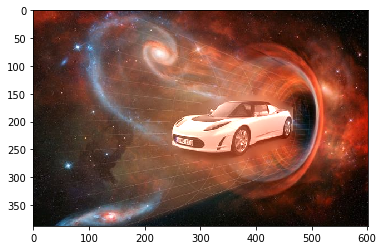

In [79]:
im_blend = poisson_blend(cropped_object, object_mask, background_img/255)
if im_blend is not None and im_blend.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_blend*255)

## Part 3 Mixed Gradients (20 pts)

In [ ]:
def mix_b(b, im, center_coord, neigh_coor, background_img, im2var, channel_cnt, e):    
    pos_src = abs(im[center_coord[0]][center_coord[1]]-im[neigh_coor[0]][neigh_coor[1]])
    pos_trgt = abs(background_img[center_coord[0]][center_coord[1]][channel_cnt]-background_img[neigh_coor[0]][neigh_coor[1]][channel_cnt])
    if pos_src > pos_trgt:
        b[e] = im[center_coord[0]][center_coord[1]]-im[neigh_coor[0]][neigh_coor[1]]
    elif pos_trgt > pos_src:
        b[e] = background_img[center_coord[0]][center_coord[1]][channel_cnt]-background_img[neigh_coor[0]][neigh_coor[1]][channel_cnt]
    
    if neigh_coor not in im2var:
        b[e] = b[e] + background_img[neigh_coor[0]][neigh_coor[1]][channel_cnt] 

In [ ]:
def mix_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    images = [cropped_object[:,:,0],cropped_object[:,:,1],cropped_object[:,:,2]]
    res_3channels = np.zeros((cropped_object.shape[0],cropped_object.shape[1],cropped_object.shape[2]),dtype=np.float64)
    channel_cnt = 0
    
    # 3 channels
    for im in images:
        print("Channel "+str(channel_cnt+1))
        # dim of source img
        im = im/255
        im_h, im_w = im.shape[0],im.shape[1] 

        # maps each pixel to a variable number
        #im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
        im2var = []
        cnt = 0
        for row in range(im_h):
            col_arr = []
            for col in range(im_w):
                if object_mask[row][col]==1:
                    col_arr.append(cnt)
                    cnt+=1
                else:
                    col_arr.append(0)
            im2var.append(col_arr)
        

        # piazza post, ask about border case and first pixel
        #n_constraints = 2*im_h*(im_w-1) + 2*(im_h-1)*im_w + 1 
        n_constraints = 4*cnt
        num_pixels = cnt
        e = 0

        # sparse matrix for A and b
        #A = np.zeros((n_constraints,num_pixels),dtype=np.float64)
        A = lil_matrix((n_constraints,num_pixels),dtype=np.float64)
        b = np.zeros(n_constraints,dtype=np.float64)

        print("Implementing Constraints")
        # calc gradient for each pixel
        for y in range(im_h):
            for x in range(im_w):
                # if pixel is part of source
                if object_mask[y][x]==1:
                    
                    mix_b(b, im,(y,x),(y,x+1), background_img, im2var, channel_cnt, e)
                    if object_mask[y][x+1]==1:
                        #obj 1 checks right 
                        A[e, im2var[y][x+1]] = -1
                        A[e, im2var[y][x]] = 1
                        e = e + 1
                    else:
                        A[e, im2var[y][x]] = 1         
                        e = e + 1
                    
                    mix_b(b, im,(y,x),(y+1,x), background_img, im2var, channel_cnt, e)
                    if object_mask[y+1][x]==1:
                        #obj 2 checks down 
                        A[e, im2var[y+1][x]] = -1
                        A[e, im2var[y][x]] = 1       
                        e = e + 1
                    else:
                        A[e, im2var[y][x]] = 1         
                        e = e + 1

                    mix_b(b, im,(y,x),(y,x-1), background_img, im2var, channel_cnt, e)
                    if object_mask[y][x-1]==1:
                        #obj 3 left  
                        A[e, im2var[y][x-1]] = -1
                        A[e, im2var[y][x]] = 1        
                        e = e + 1
                    else:
                        A[e, im2var[y][x]] = 1          
                        e = e + 1
                    
                    mix_b(b, im,(y,x),(y-1,x), background_img, im2var, channel_cnt, e)
                    if object_mask[y-1][x]==1:
                        #obj 4 checks up 
                        A[e, im2var[y-1][x]] = -1
                        A[e, im2var[y][x]] = 1         
                        e = e + 1
                    else:
                        A[e, im2var[y][x]] = 1           
                        e = e + 1

        # solve for v with least square 
        print("Solving constraints")
        v = lsqr(csr_matrix(A, dtype=np.float64), b,atol = 1e-14, btol=1e-14)
       
        # img with 1 channel
        #res_1channel = np.resize(v[0],(im_w, im_h)).T
        res_cnt = 0
        for row in range(im_h):
            for col in range(im_w):
                if object_mask[row][col]==1:
                    res_3channels[row][col][channel_cnt] = v[0][res_cnt]
                    res_cnt += 1
                else:
                    res_3channels[row][col][channel_cnt] = background_img[row][col][channel_cnt]
            
        #pdb.set_trace()
        channel_cnt+=1
    
    return res_3channels

In [ ]:
im_mix = mix_blend(cropped_object, object_mask, background_img)
if im_mix is not None and im_mix.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(img1, img2):
    pass

## More gradient domain processing (up to 20 pts)